# Motion Models
Source: Chapter 5 of Probabilistic Robotics.

## Introduction
We only focus in robots operating in planar environments.
We aim to describe a probabilistic model of kinematics, such that the outcome of a control is described by a posterior probability.
In practice, the exact shape of the model often seems less important that the fact that some provisions for uncertain outcomes are provided in the first place. In fact, many of the most successful models vastly overestimate the amount of uncertainty,


## Kinematic configuration
The kinematic state of robots operating in planar environments can be summarized by three variables $(x, y, \theta)$ describing respectively the position in 2D and the angular orientation.

We decide that $\theta = 0$ means that the robot points in the direction of its x axis.

In [190]:
import matplotlib.pyplot as plt

from math import gamma
import sys
sys.path.append("../2DProjectiveGeometry")
from math_utils import cos, sin, sqrt, atan2, exp, pi

class State:
    """
    State of a wheeled robot moving in 2D at a given time.
    """
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def __repr__(self):
        return f"State [x = {self.x}, y = {self.y}, theta = {self.theta}]"

    def as_vector(self):
        return [self.x, self.y, self.theta]

class Motion:
    """
    Defines the motion model at a given time.
    The motion model has two parameters: 
    - The transational velocity v
    - The roational velocity w
    """
    def __init__(self, v, w ):
        self.v = v
        self.w = w

    def __repr__(self):
        return f"Motion: [v = {self.v}, w = {self.w}"

    def as_vector(self):
        return [self.v, self.w]

class Robot:
    def __init__(self, state: State, motion: Motion):
        # State and control of the robot at the 
        # current moment t
        self.states = [state]
        self.motion = motion
        # Motion error parameters
        self.alpha1 = 1
        self.alpha2 = 1
        self.alpha3 = 1
        self.alpha4 = 1
        self.alpha5 = 1
        self.alpha6 = 1

    def push_new_state(self, new_state):
        self.states.append(new_state)

    def get_curr_state(self):
        return self.states[-1]

    def get_prev_state(self):
        return self.states[-2]

    def apply_control(self, ut):
        self.motion = ut

    def plot(self, ax):
        x = self.get_curr_state().x
        y = self.get_curr_state().y
        theta = self.get_curr_state().theta

        dx = 1
        dy = 0

        dx = dx * cos(theta) - dy * sin(theta)
        dy = dx * sin(theta) + dy * cos(theta)
        plt.arrow(x, y, dx, dy, width = 0.1)
        plt.plot(x, y, marker = "x", markersize = 1)




## Probabilistic kinematics
The probabilistic kinematic model, or motion model, plays the role of the state estimation model in mobile robotics. This model is the conditional density $$p(x_t | u_t, x_{t-1})$$ where the $x_i$ are the robot poses and the $u_i$ are the motion commands.

We will describe two motion models:
- One assuming that the motion data $u_t$ specifies the velocity commands given to the robot's motors.
- One assuming that one is provided with odometry information.

In practice, odometry models tend to be more accurate than velocity models, for the simple reasons that most commercial robots do not execute velocity commands with the level of accuracy that can be obtained by measuring the rotation of the robot's wheels. However odometry data is only obtained after the fact, which means that it is not suitable for motion planning, such as obstacle avoidance.

# Velocity motion model
The velocity motion model assumes that we can control a robot through two velocities, a rotational and a translational velocity.

We denote the translational velocity at time $t$ by $v_t$ and the rotational velocity at time $t$ by $w_t$. Hence we have $u_t = [v_t, w_t]$.

## Closed form solution
We want to compute the probability $P(x_t | u_t, x_{t-1})$, ie the probability of a state given a control and a previous state, assuming that the control is carried out for a duration $\Delta t$. 
We have 6 motion error parameters parameters $\alpha_1$ to $\alpha_6$ that are specific to the robot and must be estimated.

- The proposed algorithm first calculates the controls of an error-free robot.
- Then the function $\textbf{prob(x,b)}$ models the motion error, ie it computes the probability of $x$ under a zero-centered variable with variance $b$.

In [215]:
import numpy as np 

class Prob():
    def __init__(self):
        pass


class NormalDistribution(Prob):
    @staticmethod
    def compute_probability(a, b):
        first = 1 / sqrt(2 * pi * b) 
        second = exp((- a ** 2) / (2 * b))
        return first * second

    """
    Sample from a normal distribution with zero mean
    and b variance.
    """
    @staticmethod
    def sample_probability(b):
        return (b / 6) * sum(np.random.uniform(low = -1, high = 1, size = 12))

class TriangularDistribution(Prob):
    @staticmethod
    def compute_probability(a, b):
        if abs(a) > sqrt(6 * b):
            return 0
        return (sqrt(6 * b) - abs(a)) / (6 * b)

    """
    Sample from a triangular distribution with zero mean
    and b variance.
    """
    @staticmethod
    def sample_probability(b):
        return b * np.random.uniform(low = -1, high = 1) * np.random.uniform(low = -1, high = 1) 



class MotionModel:
    def __init__(self):
        self.delta_time = 1
        self.distribution = [NormalDistribution, TriangularDistribution][0]()

class VelocityMotionModel(MotionModel):
    """
    Computes the probability of the robot's current state 
    given its motion and previous state.
    """
    def motion_model_velocity(self, robot: Robot):
        state_curr = robot.get_curr_state()
        state_prev = robot.get_prev_state()
        ut = robot.motion

        xp, yp, thetap = state_curr.x, state_curr.y, state_curr.theta
        x, y, theta = state_prev.x, state_prev.y, state_prev.theta

        num_mu = (x - xp) * cos(theta) + (y - yp) * sin(theta)
        den_mu = (y - yp) * cos(theta) - (x - xp) * sin(theta)
        mu = 0.5 * (num_mu / den_mu)

        x_star = 0.5 * (x + xp) + mu * (y - yp)
        y_star = 0.5 * (y + yp) + mu * (xp - x)
        r_star = sqrt((x - x_star)**2 + (y - y_star)**2)

        delta_theta = atan2(yp - y_star, xp - x_star) - atan2(y - y_star, x - x_star)

        v_hat = (delta_theta / self.delta_time) * r_star
        w_hat = delta_theta / self.delta_time
        gamma_hat = ((thetap - theta) / self.delta_time) - w_hat

        first = self.distribution.compute_probability(ut.v - v_hat, robot.alpha1 * abs(ut.v) + robot.alpha2 * abs(ut.w))
        second = self.distribution.compute_probability(ut.w - w_hat, robot.alpha3 * abs(ut.v) + robot.alpha4 * abs(ut.w))
        third = self.distribution.compute_probability(gamma_hat, robot.alpha5 * abs(ut.v) + robot.alpha6 * abs(ut.w))
        
        return first * second * third

    """
    Samples a new state x_t knowing the previous one and a control.
    """
    def sample_motion_model_velocity(self, robot: Robot):
        v = robot.motion.v
        w = robot.motion.w
        state_prev = robot.get_curr_state()
        x, y, theta = state_prev.x, state_prev.y, state_prev.theta

        v_hat = v + self.distribution.sample_probability(robot.alpha1 * abs(v) + robot.alpha2 * abs(w))
        w_hat = w + self.distribution.sample_probability(robot.alpha3 * abs(v) + robot.alpha4 * abs(w))
        gamma_hat = self.distribution.sample_probability(robot.alpha5  * abs(v) + robot.alpha6 * abs(w))

        xp = x - (v_hat / w_hat) * sin(theta) + (v_hat / w_hat) * sin(theta + w_hat * self.delta_time)
        yp = y + (v_hat / w_hat) * cos(theta) - (v_hat / w_hat) * cos(theta + w_hat * self.delta_time)
        thetap = theta + w_hat * self.delta_time + gamma_hat * self.delta_time
        return State(xp, yp, thetap)

    class OdometryMotionModel(MotionModel):
        def __init__():
            pass

In [216]:
""" 
Setup a test robot
In order to test, the robot needs:
- A previous state
- A motion control

We query then different hypothetic current states to get 
the probability of them
"""

prev_state = State(x = 0, y = 0, theta = 0)
motion_control = Motion(v = 1, w = 0)
myRobot = Robot(state = prev_state, motion = motion_control) 
new_state = State(x = 1, y = -0.1, theta = 0.2)
myRobot.push_new_state(new_state)

velocityModel = VelocityMotionModel()
velocityModel.motion_model_velocity(myRobot)

0.007675643875862971

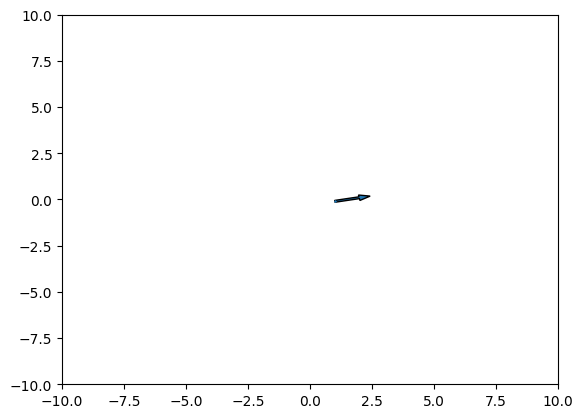

In [217]:
# Display the result for different states.
import matplotlib.pyplot as plt

study_square_area = 10
ax = plt.subplot()
plt.xlim(-study_square_area, study_square_area)
plt.ylim(-study_square_area, study_square_area)
myRobot.plot(ax)

In [218]:
from collections import namedtuple
from copy import deepcopy
# Iterate over possible states and save the probabilities
# Then plot them as opacities

# Tuple used to hold the probability for each sample point
##stateProbability = namedtuple("stateProbability", "x y probability")
state_probabilities = []

# Define the grid search and a way to map each sample point to the robot space
steps = 10
states = []
togrid = lambda x: (x / steps) * (study_square_area - (-study_square_area)) - study_square_area

# Define the robot and the motion applied
prev_state = State(x = 0, y = 0, theta = 0)
motion_control = Motion(v = 1, w = 0)
myRobot = Robot(state = prev_state, motion = motion_control) 
velocityModel = VelocityMotionModel()

# Query the probabilities for the state following the motion
for index_x in range(steps + 1):
    probabilities = []
    for index_y in range(steps + 1):
        x = togrid(index_x)
        y = togrid(index_y)
        state = State(x = x, y = y, theta = 0)
        myRobot.push_new_state(state)
        prob = velocityModel.motion_model_velocity(myRobot)
      
        probabilities.append(deepcopy(prob))
        #state_probabilities.append(stateProbability(x, y, prob))
  
    state_probabilities.append(probabilities)


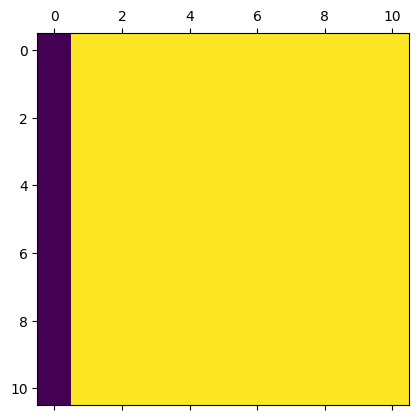

In [219]:
import numpy as np
plt.matshow(state_probabilities)
plt.show()

In [220]:
# Sample motion model
state = State(x = 0, y = 0, theta = 0)
motion_control = Motion(v = 2, w = 0)
myRobot = Robot(state = state, motion = motion_control) 
velocityModel = VelocityMotionModel()

sampled_states = []
for _ in range(500):
    sampled_states.append(velocityModel.sample_motion_model_velocity(myRobot))

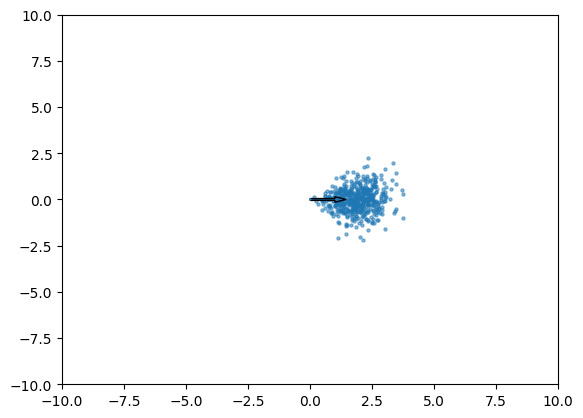

In [221]:
plt.figure()
ax = plt.subplot()
plt.scatter(x = [s.x for s in sampled_states], y = [s.y for s in sampled_states], s = 5, alpha = 0.5)
plt.xlim(-study_square_area, study_square_area)
plt.ylim(-study_square_area, study_square_area)
myRobot.plot(ax)
plt.show()